# Importing Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from imblearn.over_sampling import SMOTE 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score,auc

#### Data Importing & Data Understanding 

In [4]:
df = pd.read_csv("input/nearest-earth-objects(1910-2024).csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [5]:
df.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [6]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


<b>Checking</b> the number of duplicated rows

In [8]:
df.duplicated().sum()

0

# Exploratory Data Analysis

### Dealing With Missing Values

<b>Checking</b> number of missing of values in each row

In [12]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

<b>Result:</b> This indicates that there are 28 missing values in the columns absolute_magnitude, estimated_diameter_min, and estimated_diameter_max.

 Finding the number of missing values in each row

In [15]:
df.isnull().sum(axis = 1).sort_values(ascending = False)

271995    3
274626    3
111671    3
274580    3
153108    3
         ..
112731    0
112730    0
112729    0
112728    0
338198    0
Length: 338199, dtype: int64

<b>Result:</b> Determined missing values in rows.

These two steps (above) are useful in data preprocessing to understand the distribution of missing values in datasets to decide how to handle them.

<br>

<b>Filling</b> missing values in 'absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max' with the mean of those columns.

In [20]:
imputer = SimpleImputer(strategy='mean')

df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max']] = imputer.fit_transform(df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max']])

missing_values_after_imputation = df.isnull().sum()
missing_values_after_imputation

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

<b>Why:</b> <li>Imputation is a common technique in data preprocessing to handle missing values. Filling in missing values with the mean is a simple effective way, especially when the data is numerical and has a roughly normal distribution.</li>
<li>This step ensures that all values are present, preventing errors during model training.</li>

<br>

In [23]:
df.columns

Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous'],
      dtype='object')

<br>

<b>Counts</b> of unique values

In [26]:
df['is_hazardous'].value_counts()

is_hazardous
False    295037
True      43162
Name: count, dtype: int64

<b>Imbalanced Data:</b> The 'is_hazardous' column is imbalanced, with significantly more False values than True values.

## Data Visualization

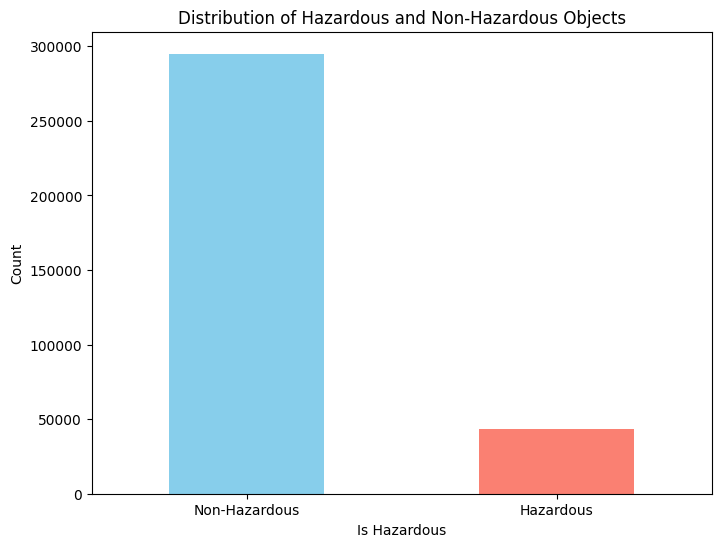

In [29]:
hazardous_counts = df['is_hazardous'].value_counts()

plt.figure(figsize=(8, 6))
hazardous_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Hazardous and Non-Hazardous Objects')
plt.xlabel('Is Hazardous')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Hazardous', 'Hazardous'], rotation=0)
plt.show()

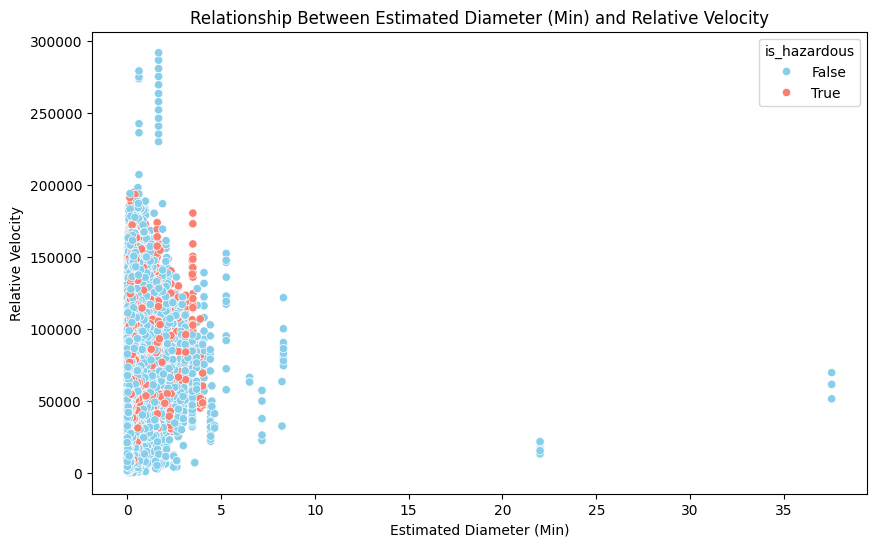

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='estimated_diameter_min', y='relative_velocity', hue='is_hazardous', palette=['skyblue', 'salmon'])
plt.title('Relationship Between Estimated Diameter (Min) and Relative Velocity')
plt.xlabel('Estimated Diameter (Min)')
plt.ylabel('Relative Velocity')
plt.show()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_11036\24564343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_hazardous', y='estimated_diameter_min', palette=['skyblue', 'salmon'])


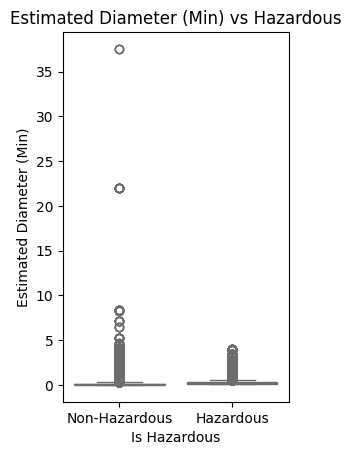

In [31]:
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='is_hazardous', y='estimated_diameter_min', palette=['skyblue', 'salmon'])
plt.title('Estimated Diameter (Min) vs Hazardous')
plt.xlabel('Is Hazardous')
plt.ylabel('Estimated Diameter (Min)')
plt.xticks(ticks=[0, 1], labels=['Non-Hazardous', 'Hazardous'])

plt.show()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_11036\4104973974.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_hazardous', y='estimated_diameter_max', palette=['skyblue', 'salmon'])


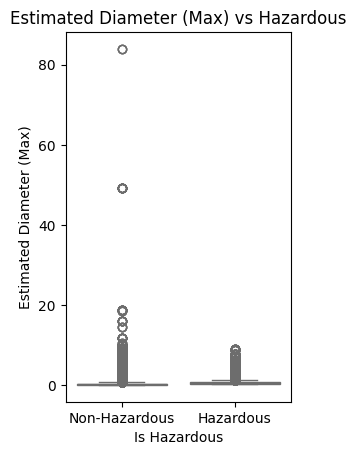

In [32]:
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='is_hazardous', y='estimated_diameter_max', palette=['skyblue', 'salmon'])
plt.title('Estimated Diameter (Max) vs Hazardous')
plt.xlabel('Is Hazardous')
plt.ylabel('Estimated Diameter (Max)')
plt.xticks(ticks=[0, 1], labels=['Non-Hazardous', 'Hazardous'])

plt.show()

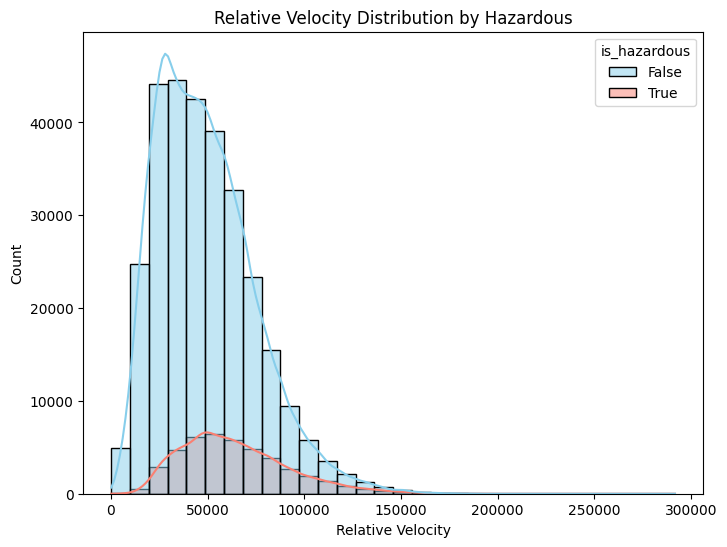

In [33]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='relative_velocity', hue='is_hazardous', bins=30, kde=True, palette=['skyblue', 'salmon'])
plt.title('Relative Velocity Distribution by Hazardous')
plt.xlabel('Relative Velocity')
plt.show()

C:\Users\b_sen\AppData\Local\Temp\ipykernel_11036\12635243.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['is_hazardous'] == False]['relative_velocity'],


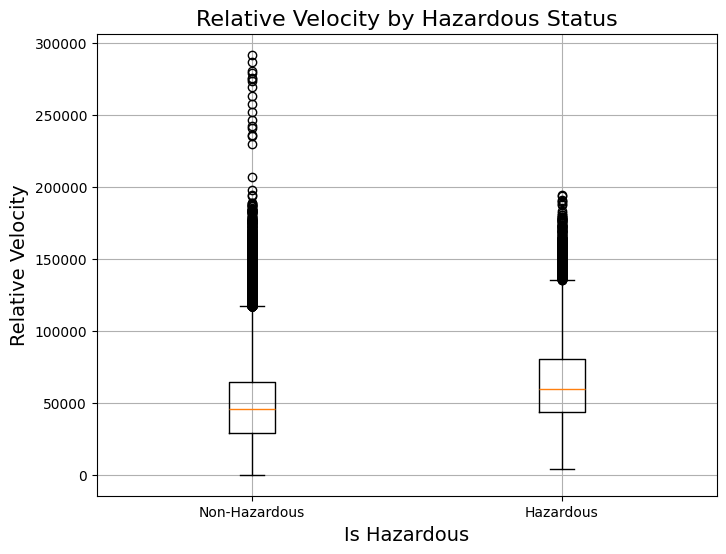

In [34]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['is_hazardous'] == False]['relative_velocity'],
             df[df['is_hazardous'] == True]['relative_velocity']],
            labels=['Non-Hazardous', 'Hazardous'])

plt.title('Relative Velocity by Hazardous Status', fontsize=16)
plt.xlabel('Is Hazardous', fontsize=14)
plt.ylabel('Relative Velocity', fontsize=14)
plt.grid(True)
plt.show()

### Correlation Matrix

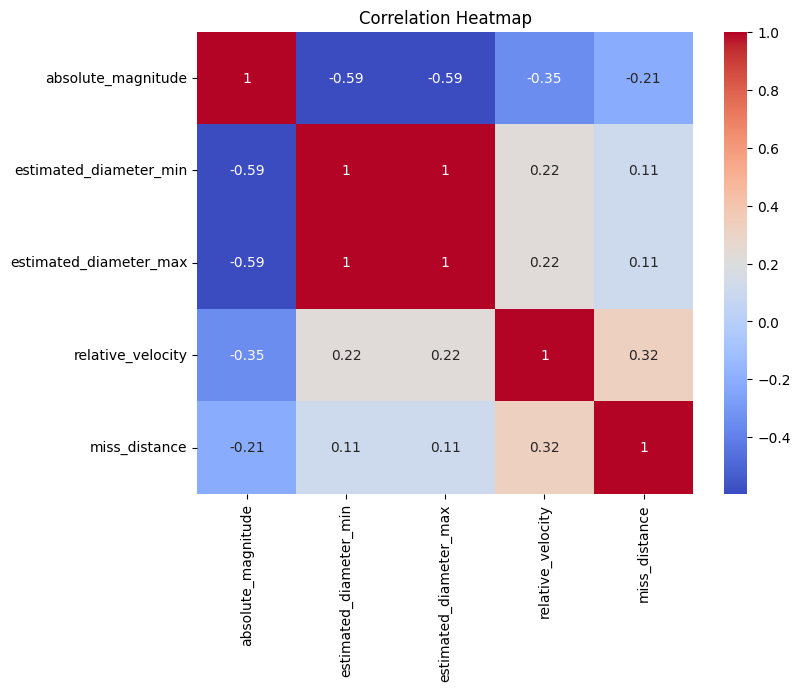

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Identification of Categorical and Numerical Features

The dataset has been analyzed to identify categorical and numerical features.

In [39]:
categorical_features = df.select_dtypes(include=['object', 'category','bool']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['name', 'orbiting_body', 'is_hazardous']
Numerical Features: ['neo_id', 'absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']


#### Encoding Categorical Features

The categorical features in the dataset have been encoded using label encoding.

In [42]:
label_encoding = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoding.fit_transform(df[col])

In [43]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,30603,19.14,0.394962,0.883161,0,71745.401048,5.814362e+07,0
1,2349507,31395,18.50,0.530341,1.185878,0,109949.757148,5.580105e+07,1
2,2455415,32118,21.45,0.136319,0.304818,0,24865.506798,6.720689e+07,0
3,3132126,736,20.63,0.198863,0.444672,0,78890.076805,3.039644e+07,0
4,3557844,4880,22.70,0.076658,0.171412,0,56036.519484,6.311863e+07,0


#### Correlation Analysis

In [45]:
correlation_matrix = df.corr()
print(correlation_matrix['is_hazardous'].sort_values(ascending=False))

is_hazardous              1.000000
relative_velocity         0.187021
estimated_diameter_min    0.164840
estimated_diameter_max    0.164840
name                      0.120058
miss_distance            -0.006540
neo_id                   -0.156748
absolute_magnitude       -0.343994
orbiting_body                  NaN
Name: is_hazardous, dtype: float64


#### Dropping Irrelevant Columns

In [47]:
df = df.drop(columns=['name', 'neo_id', 'orbiting_body', ])

In [48]:
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,0
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,1
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,0
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,0
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,0


#### Feature Scaling

The numerical features in the dataset were standardized to have a mean of 0 and a standard deviation of 1 using the `StandardScaler`.
Standardization is a common preprocessing that helps in normalizing the range of independent variables or features of data.

In [51]:
numerical_features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
                       'relative_velocity', 'miss_distance']

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [52]:
df

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,-1.302784,0.755562,0.755562,0.783537,0.799476,0
1,-1.522633,1.186882,1.186882,2.230715,0.686711,1
2,-0.509268,-0.068479,-0.068479,-0.992271,1.235756,0
3,-0.790949,0.130790,0.130790,1.054176,-0.536196,0
4,-0.079876,-0.258559,-0.258559,0.188485,1.038958,0
...,...,...,...,...,...,...
338194,1.939985,-0.486506,-0.486506,0.211610,1.084537,0
338195,1.977772,-0.487310,-0.487310,-1.133742,-0.579886,0
338196,-0.348160,-0.152844,-0.152844,-1.485978,0.574057,0
338197,0.327875,-0.361407,-0.361407,0.194617,-1.749816,0


### Feature Selection and Normalization

In [54]:
selected_features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
                     'relative_velocity', 'miss_distance']
X = df[selected_features]
y = df['is_hazardous']

In [55]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Supervised Learning

## 1.1 Logistic Regression
Logistic Regression was applied to the dataset to predict whether a near-Earth object is hazardous.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [59]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [60]:
y_pred_log_reg = log_reg_model.predict(X_test)

In [61]:
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

In [62]:
print(f"Accuracy: {accuracy_log_reg}")
print("Classification Report:")
print(classification_rep_log_reg)
print("Confusion Matrix:")
print(conf_matrix_log_reg)

Accuracy: 0.8693672383205204
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     59011
           1       0.41      0.06      0.10      8629

    accuracy                           0.87     67640
   macro avg       0.64      0.52      0.51     67640
weighted avg       0.82      0.87      0.82     67640

Confusion Matrix:
[[58317   694]
 [ 8142   487]]


***Evaluation***:
- The model achieved a high accuracy rate, but this may be influenced by the class imbalance in the dataset.
- The precision and recall for the hazardous class (1) are relatively low, indicating that the model struggles to correctly identify hazardous objects.
- This suggests that further tuning or a different approach might be needed to improve the detection of hazardous objects.

#### 1.2 Hyperparameter Tuning with RandomizedSearchCV

In this step, hyperparameter tuning was performed on the Logistic Regression model to improve its performance.

In [66]:
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 500]
}

In [67]:
log_reg = LogisticRegression(random_state=42)

In [68]:
random_search_log_reg = RandomizedSearchCV(
    estimator=log_reg, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5,
    verbose=2,     
    random_state=42,      
    n_jobs=-1 
)

In [69]:
random_search_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 200, 500],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, verbose=2)

**Best Parameters and Score**:
   - After the search, the best parameters were extracted using `best_params_`.
   - The best score was also obtained using `best_score_`.

In [71]:
best_params_log_reg = random_search_log_reg.best_params_
best_score_log_reg = random_search_log_reg.best_score_

print("Best Parameters:", best_params_log_reg)
print("Best Score:", best_score_log_reg)

Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 100}
Best Score: 0.871724836363971


**ROC Curve Plotting**:
   - The Receiver Operating Characteristic (ROC) curve was plotted to visualize the performance of the model with the best-found parameters.

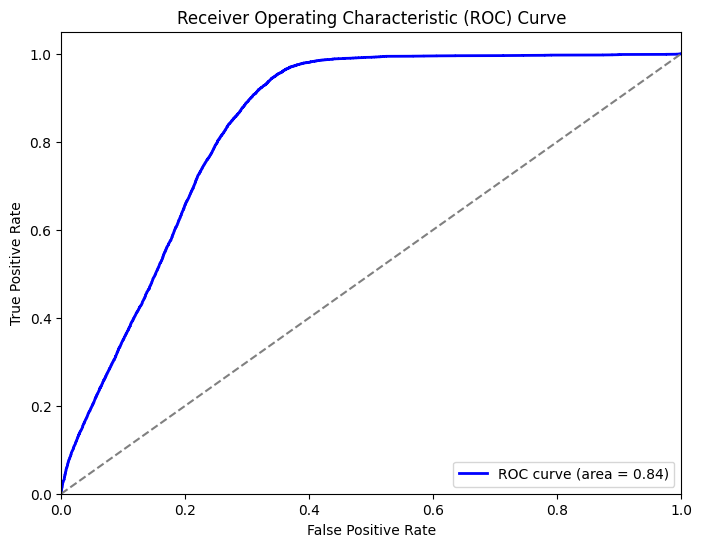

In [73]:
y_pred_proba = random_search_log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The model's training accuracy and testing accuracy were calculated and stored in a tabular format for easy reference and comparison with other models.

In [75]:
test_score = accuracy_score(y_test, random_search_log_reg.predict(X_test)) * 100
train_score = accuracy_score(y_train, random_search_log_reg.predict(X_train)) * 100

results_df1 = pd.DataFrame(data=[["Best Logistic Regression", train_score, test_score]],
                          columns=['Model', 'Training Accuracy', 'Testing Accuracy'])

## 2.1 Random Forest Classifier

A Random Forest Classifier was used to train the model on the dataset. The model was trained and tested to assess its performance.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [79]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [80]:
y_pred_rf = rf_model.predict(X_test)

In [81]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

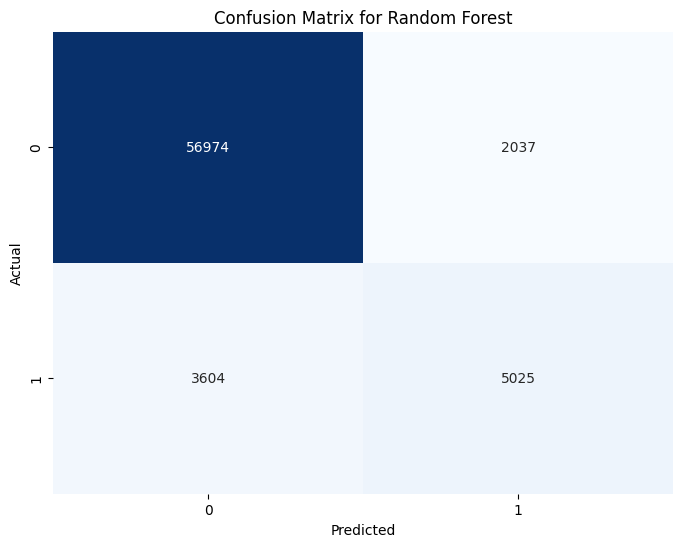

In [82]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [83]:
performance_results = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}
performance_results

{'Accuracy': 0.9166026020106446,
 'Precision': 0.7115548003398471,
 'Recall': 0.5823386255649554,
 'F1 Score': 0.6404945510165063}

***Evaluation***
- The model shows good performance with an overall accuracy of 91.08%.
- However, there is still room for improvement, especially in identifying hazardous objects as indicated by the recall and precision scores.

**Creating a function for evaluations**

In [86]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        cm = confusion_matrix(y_train, pred)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix - Train Data')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        cm = confusion_matrix(y_test, pred)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix - Test Data')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

#### 2.2 Hyperparameter Tuning using RandomizedSearchCV

- Hyperparameter tuning was conducted using RandomizedSearchCV to find the optimal parameters for the Random Forest Classifier.
- This process helps improve the model's performance by testing different combinations of hyperparameters.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': None}
Train Result:
Accuracy Score: 95.00%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.954748      0.904859  0.949967       0.929804       0.948380
recall          0.989548      0.679437  0.949967       0.834492       0.949967
f1-score        0.971836      0.776111  0.949967       0.873974       0.946855
support    236026.000000  34533.000000  0.949967  270559.000000  270559.000000
_______________________________________________


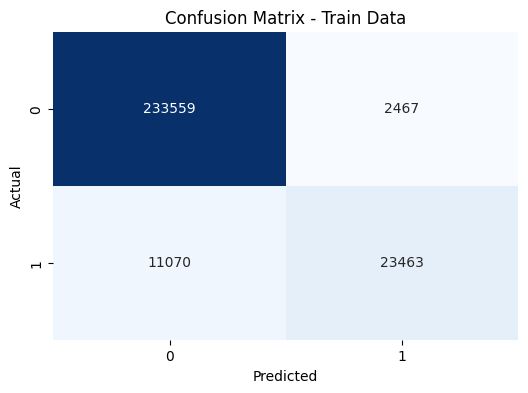

Test Result:
Accuracy Score: 91.08%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.927723     0.727066  0.910778      0.827394      0.902124
recall         0.973581     0.481284  0.910778      0.727433      0.910778
f1-score       0.950099     0.579179  0.910778      0.764639      0.902780
support    59011.000000  8629.000000  0.910778  67640.000000  67640.000000
_______________________________________________


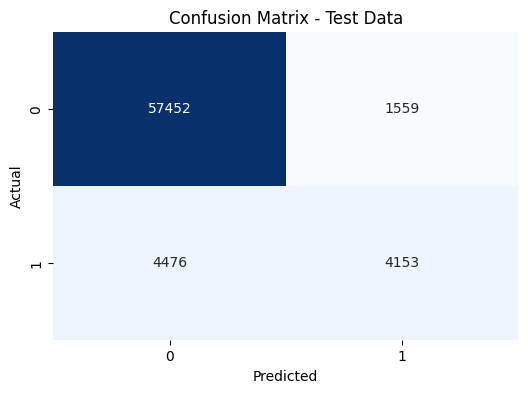

In [89]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],      
    'max_depth': [10, 20, 30, None],           
    'min_samples_split': [2, 10, 20],          
    'min_samples_leaf': [1, 5, 10]     
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,          
    param_distributions=param_grid, 
    n_iter=10,            
    cv=5,                  
    verbose=2,             
    random_state=42,     
    n_jobs=-1            
)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_
print_score(best_rf, X_train, y_train, X_test, y_test, train=True)
print_score(best_rf, X_train, y_train, X_test, y_test, train=False)

***Dealing with Imbalanced Data using SMOTE***
- The dataset was imbalanced, with significantly more instances of non-hazardous objects compared to hazardous ones.
- This imbalance can lead to biased model predictions, favoring the majority class (non-hazardous).

In [91]:
X = df.drop(columns=['is_hazardous'])
y = df['is_hazardous']

In [92]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

Original y distribution: is_hazardous
0    295037
1     43162
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    295037
1    295037
Name: count, dtype: int64


- Synthetic Minority Over-sampling Technique (SMOTE) was applied to balance the dataset by generating synthetic samples for hazardous objects.
- By applying SMOTE, a balanced dataset was created, which should help the model learn to recognize hazardous objects more effectively.

#### 2.3 Random Forest Classifier with SMOTE

****Data Splitting:****

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

****Hyperparameter Tuning:****

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': None}
Train Result:
Accuracy Score: 96.88%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.979937       0.958178  0.968796       0.969057   
recall          0.957143       0.980432  0.968796       0.968788   
f1-score        0.968406       0.969177  0.968796       0.968792   
support    235855.000000  236204.000000  0.968796  472059.000000   

            weighted avg  
precision       0.969049  
recall          0.968796  
f1-score        0.968792  
support    472059.000000  
_______________________________________________


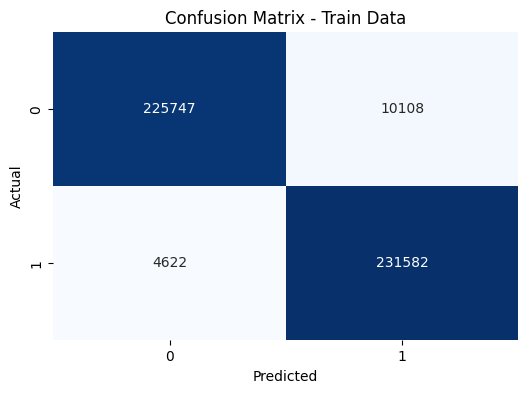

Test Result:
Accuracy Score: 94.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.960654      0.920964  0.939982       0.940809       0.940868
recall         0.917914      0.962181  0.939982       0.940048       0.939982
f1-score       0.938798      0.941122  0.939982       0.939960       0.939956
support    59182.000000  58833.000000  0.939982  118015.000000  118015.000000
_______________________________________________


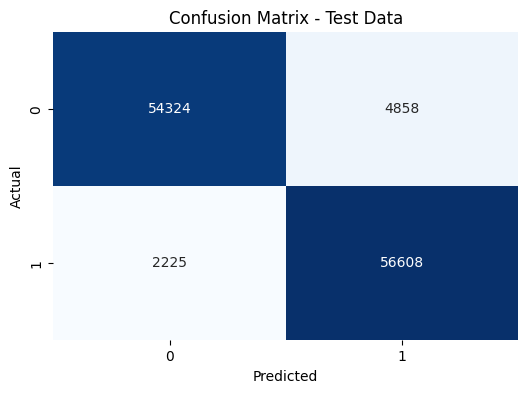

In [98]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],      
    'max_depth': [10, 20, 30, None],           
    'min_samples_split': [2, 10, 20],          
    'min_samples_leaf': [1, 5, 10]     
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,          
    param_distributions=param_grid, 
    n_iter=10,            
    cv=5,                  
    verbose=2,             
    random_state=42,     
    n_jobs=-1            
)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_
print_score(best_rf, X_train, y_train, X_test, y_test, train=True)
print_score(best_rf, X_train, y_train, X_test, y_test, train=False)


1. **Confusion Matrix and Classification Report for Test Data**:
- The confusion matrix shows that the Random Forest model performed quite well in distinguishing between hazardous and non-hazardous objects.
- The overall accuracy of the model on the test data is 94%.
- This suggests that the Random Forest classifier is highly effective in predicting whether an object is hazardous.

2. **Confusion Matrix and Classification Report for Train Data:**
- Model showed high accuracy on the training data as well, with an accuracy of 96.88%.
- This indicates that the model was well-trained without significant overfitting.

****ROC Curve:****

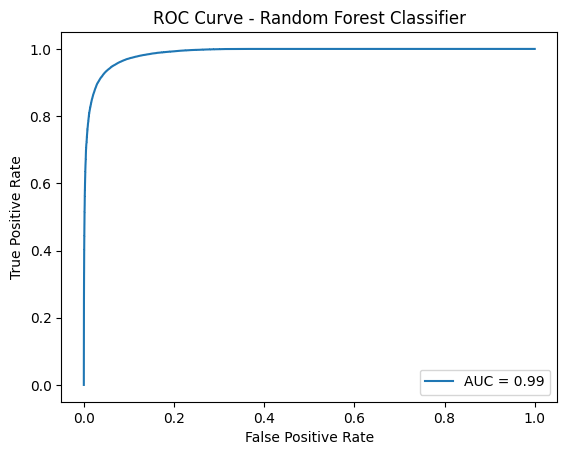

In [101]:
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba) 
roc_auc = roc_auc_score(y_test, y_pred_proba)  

plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc=4)
plt.show()

- The ROC Curve for the Random Forest model shows a high area under the curve (AUC) of 0.99, indicating excellent performance.
- A high AUC value signifies that the model is highly capable of distinguishing between the positive and negative classes.
- The curve rises sharply towards the top-left corner, which means the model has a high True Positive Rate and a low False Positive Rate, further confirming its strong predictive ability.

In [103]:
test_score = accuracy_score(y_test, best_rf.predict(X_test)) * 100
train_score = accuracy_score(y_train, best_rf.predict(X_train)) * 100

results_df2 = pd.DataFrame(data=[["Best RF", train_score, test_score]],
                          columns=['Model', 'Training Accuracy', 'Testing Accuracy'])
results_df = pd.concat([results_df1, results_df2], ignore_index=True)
results_df

,Model,Training Accuracy,Testing Accuracy
0,Best Logistic Regression,87.173592,87.174749
1,Best RF,96.879627,93.998221


# Unsupervised Learning
### K-Means Clustering

In [105]:
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,-1.302784,0.755562,0.755562,0.783537,0.799476,0
1,-1.522633,1.186882,1.186882,2.230715,0.686711,1
2,-0.509268,-0.068479,-0.068479,-0.992271,1.235756,0
3,-0.790949,0.130790,0.130790,1.054176,-0.536196,0
4,-0.079876,-0.258559,-0.258559,0.188485,1.038958,0


**Sampling and Preparation:**

In [107]:
sample_data = df.sample(n=30000, random_state=42)

In [108]:
X_kmeans_sample = sample_data[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']]

**Finding the Optimal Number of Clusters:**

In [110]:
inertia = []
silhouette_scores = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans_sample)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_kmeans_sample, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\clust

**Elbow Method:** 
-The Elbow method was used to determine the optimal number of clusters `k`. By plotting the inertia (sum of squared distances) for different `k` values (ranging from 2 to 10), the point where the curve starts to bend (the elbow) indicates the optimal `k`.

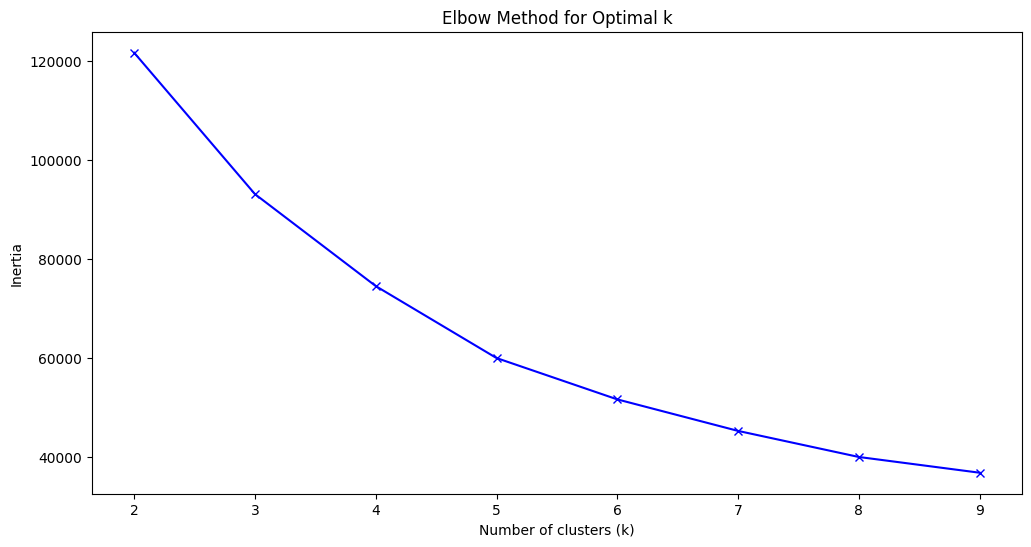

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

The scores slightly decrease as `k` increases, with `k=3` providing a reasonable balance.

**Silhouette Score:** 
- The Silhouette score for different `k` values was also plotted to support the choice of `k`. 
- The score measures how similar an object is to its own cluster compared to other clusters.
- Higher scores indicate better-defined clusters.

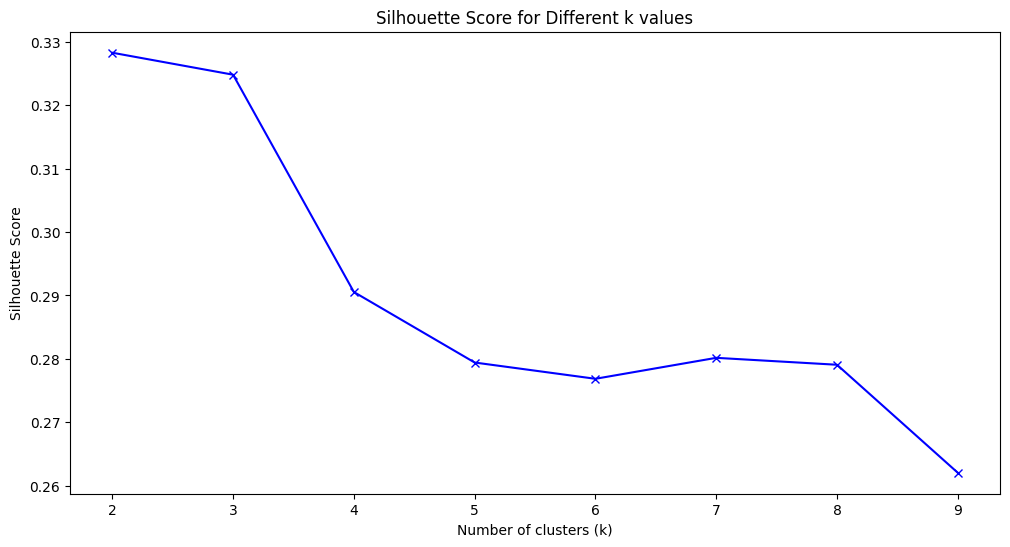

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k values')
plt.show()

The scores slightly decrease as `k` increases, with `k=3` providing a reasonable balance.

***Clustering with K-Means:***
- K-Means was applied with `k=3`.

In [118]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_kmeans_sample)

C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [119]:
sample_data['kmeans_cluster'] = kmeans.labels_

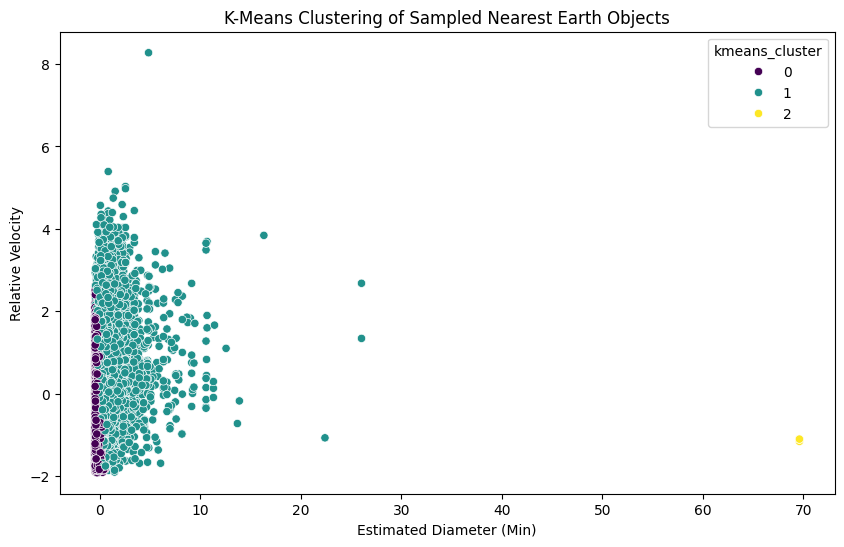

In [120]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='estimated_diameter_min', y='relative_velocity', hue='kmeans_cluster', palette='viridis')
plt.title('K-Means Clustering of Sampled Nearest Earth Objects')
plt.xlabel('Estimated Diameter (Min)')
plt.ylabel('Relative Velocity')
plt.show()

Cluster centers (means) and a summary of statistical descriptions for each cluster were calculated to understand the characteristics of each cluster.

In [122]:
cluster_centers = sample_data.groupby('kmeans_cluster').mean()
print("Cluster Centers (Means):")
print(cluster_centers)

Cluster Centers (Means):
                absolute_magnitude  estimated_diameter_min  \
kmeans_cluster                                               
0                         0.499813               -0.326016   
1                        -1.014233                0.647094   
2                        -4.301660               69.610902   

                estimated_diameter_max  relative_velocity  miss_distance  \
kmeans_cluster                                                             
0                            -0.326016          -0.387428      -0.245746   
1                             0.647094           0.772440       0.444184   
2                            69.610902          -1.126101      -0.119014   

                is_hazardous  
kmeans_cluster                
0                   0.059492  
1                   0.269104  
2                   0.000000  


**Cluster Analysis:**

In [124]:
cluster_summary = sample_data.groupby('kmeans_cluster').describe()
print("\nCluster Summary (Statistical Descriptions):")
print(cluster_summary)


Cluster Summary (Statistical Descriptions):
               absolute_magnitude                                          \
                            count      mean       std       min       25%   
kmeans_cluster                                                              
0                         19986.0  0.499813  0.756970 -1.319960 -0.103921   
1                         10011.0 -1.014233  0.550333 -3.576846 -1.340571   
2                             3.0 -4.301660  0.000000 -4.301660 -4.301660   

                                             estimated_diameter_min  \
                     50%       75%       max                  count   
kmeans_cluster                                                        
0               0.473182  1.052861  3.441140                19986.0   
1              -0.990187 -0.677589  1.215171                10011.0   
2              -4.301660 -4.301660 -4.301660                    3.0   

                           ... miss_distance           is_hazardo

In [125]:
cluster_sizes = sample_data['kmeans_cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
kmeans_cluster
0    19986
1    10011
2        3
Name: count, dtype: int64


**Hazardous Analysis by Cluster:**

In [127]:
hazardous_means = sample_data.groupby('kmeans_cluster')['is_hazardous'].mean()

hazardous_counts = sample_data.groupby('kmeans_cluster')['is_hazardous'].sum()
total_counts = sample_data['kmeans_cluster'].value_counts()

hazardous_percentage = (hazardous_counts / total_counts) * 100

In [128]:
hazardous_summary = pd.DataFrame({
    'Hazardous Mean': hazardous_means,
    'Hazardous Count': hazardous_counts,
    'Total Count': total_counts,
    'Hazardous Percentage (%)': hazardous_percentage
})

In [129]:
print("Hazardous Analysis by Cluster:")
print(hazardous_summary)

Hazardous Analysis by Cluster:
                Hazardous Mean  Hazardous Count  Total Count  \
kmeans_cluster                                                 
0                     0.059492             1189        19986   
1                     0.269104             2694        10011   
2                     0.000000                0            3   

                Hazardous Percentage (%)  
kmeans_cluster                            
0                               5.949164  
1                              26.910399  
2                               0.000000  


The results indicate that Cluster 1 has a significantly higher proportion of hazardous objects compared to Cluster 0.

**Evaluation Metrics:**

1. *Silhouette Score:* 
- A value closer to 1 indicates that the samples are well-clustered and are far away from neighboring clusters.
- A score close to 0 indicates overlapping clusters, where samples are near the decision boundary between clusters.
- Negative values mean that samples are likely assigned to the wrong clusters.

2. *Calinski-Harabasz Index:*
- Higher values indicate better-defined clusters.
- This index measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion.
- Higher values indicate that clusters are dense and well separated.

3. *Davies-Bouldin Score:*
- This score measures the average similarity ratio of each cluster with the one that is most similar to it.
- Lower values indicate better clustering, where clusters are compact and well-separated from one another.

In [133]:
silhouette_avg = silhouette_score(X_kmeans_sample, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

calinski_harabasz = calinski_harabasz_score(X_kmeans_sample, kmeans.labels_)
print(f'Calinski-Harabasz Score: {calinski_harabasz}')

davies_bouldin = davies_bouldin_score(X_kmeans_sample, kmeans.labels_)
print(f'Davies-Bouldin Score: {davies_bouldin}')

Silhouette Score: 0.3248038012713292
Calinski-Harabasz Score: 11144.790053903534
Davies-Bouldin Score: 0.8583237421754547


**Principal Component Analysis (PCA):**
- PCA is a technique used for dimensionality reduction.
- It transforms the original dataset into a lower-dimensional space, keeping the most important variance from the original data.

In [135]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans_sample)

In [136]:
kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(X_pca)

C:\Users\b_sen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

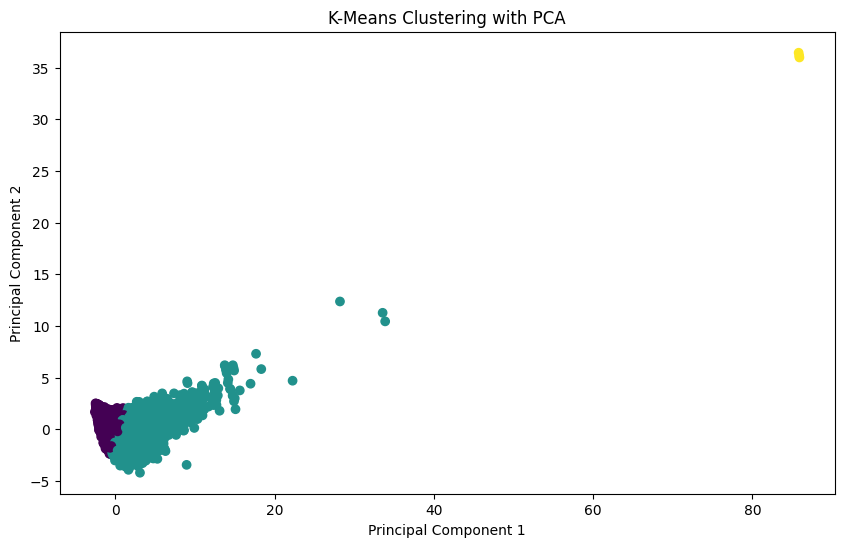

In [137]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [138]:
silhouette_avg_pca = silhouette_score(X_pca, kmeans_pca.labels_)
calinski_harabasz_pca = calinski_harabasz_score(X_pca, kmeans_pca.labels_)
davies_bouldin_pca = davies_bouldin_score(X_pca, kmeans_pca.labels_)

In [139]:
print(f'Silhouette Score after PCA: {silhouette_avg_pca}')
print(f'Calinski-Harabasz Score after PCA: {calinski_harabasz_pca}')
print(f'Davies-Bouldin Score after PCA: {davies_bouldin_pca}')

Silhouette Score after PCA: 0.42347678068515093
Calinski-Harabasz Score after PCA: 15618.428777227307
Davies-Bouldin Score after PCA: 0.6642574357074443


**Results:**
- Silhouette Score has increased, showing that the separation between clusters improved after reducing dimensions.
- Calinski-Harabasz Score increased, indicating that the clusters are more compact and better-separated after PCA.
- Davies-Bouldin Score decreased, further confirming that the clusters are more well-defined and less overlapping post-PCA.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
- DBSCAN is a density-based clustering algorithm that is designed to find clusters in data by identifying areas of high density.
- DBSCAN focuses on grouping points that are closely packed together in space, and marking points that don't belong to any dense region as noise.

In [142]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

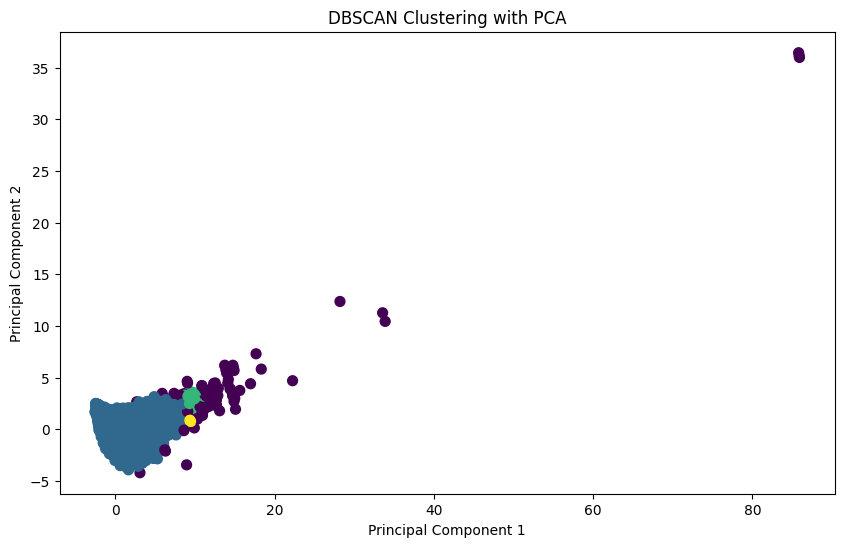

In [143]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [144]:
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN Cluster Count: {n_clusters_dbscan}")

DBSCAN Cluster Count: 3


In [145]:
silhouette_avg_dbscan = silhouette_score(X_pca, dbscan_labels)
calinski_harabasz_dbscan = calinski_harabasz_score(X_pca, dbscan_labels)
davies_bouldin_dbscan = davies_bouldin_score(X_pca, dbscan_labels)

In [146]:
print(f"DBSCAN - Silhouette Score: {silhouette_avg_dbscan}")
print(f"DBSCAN - Calinski-Harabasz Score: {calinski_harabasz_dbscan}")
print(f"DBSCAN - Davies-Bouldin Score: {davies_bouldin_dbscan}")

DBSCAN - Silhouette Score: 0.7758458575999244
DBSCAN - Calinski-Harabasz Score: 2148.469072399772
DBSCAN - Davies-Bouldin Score: 1.1802851903740637


**Results:**
- DBSCAN performs significantly better in terms of the Silhouette Score, meaning the clusters it forms are better separated and more internally consistent compared to K-Means.
- However, the Calinski-Harabasz and Davies-Bouldin Scores show that DBSCAN's clusters are less compact and have more overlap than K-Means with PCA.
- These results suggest that DBSCAN is highly effective in separating clusters in this dataset based on density, but its clusters may not be as well-defined in terms of compactness as those produced by K-Means with PCA.

**Gaussian Mixture Model (GMM) Clustering:**
- GMM is a probabilistic clustering approach that assumes that data is generated from a mixture of several Gaussian distributions with unknown parameters.
- GMM assigns a probability to each point for belonging to each cluster, allowing for more flexibility and adaptability in clustering.
- It is especially useful when clusters have different shapes, sizes, and densities.

In [149]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

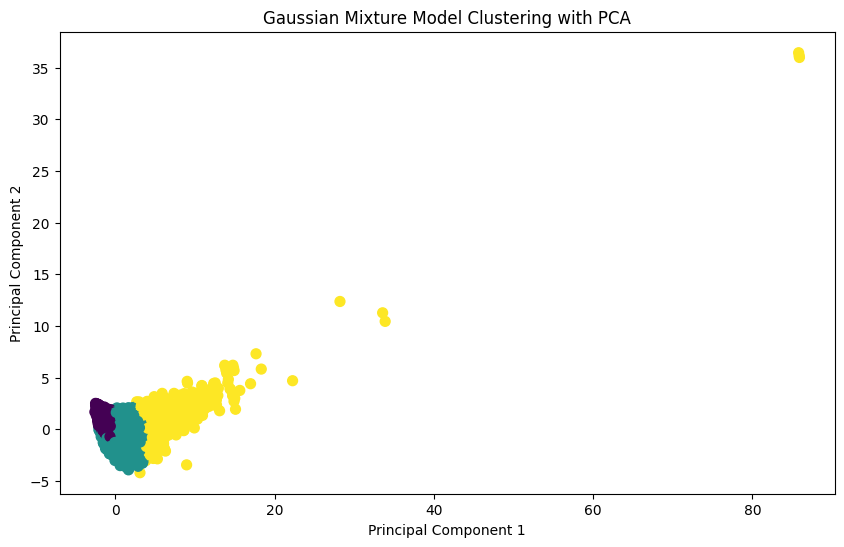

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Model Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [151]:
n_clusters_gmm = len(set(gmm_labels))
print(f"GMM Cluster Count: {n_clusters_gmm}")

GMM Cluster Count: 3


In [152]:
silhouette_avg_gmm = silhouette_score(X_pca, gmm_labels)
calinski_harabasz_gmm = calinski_harabasz_score(X_pca, gmm_labels)
davies_bouldin_gmm = davies_bouldin_score(X_pca, gmm_labels)

In [153]:
print(f"\nGMM - Silhouette Score: {silhouette_avg_gmm}")
print(f"GMM - Calinski-Harabasz Score: {calinski_harabasz_gmm}")
print(f"GMM - Davies-Bouldin Score: {davies_bouldin_gmm}")


GMM - Silhouette Score: 0.3629355591256231
GMM - Calinski-Harabasz Score: 12343.803911161185
GMM - Davies-Bouldin Score: 0.9220483570739377


**Results:**
- GMM has a lower *Silhouette Score* compared to DBSCAN and K-Means, indicating that the clusters are not as well-separated. This is expected with GMM's soft clustering approach, where some data points belong to multiple clusters.
- The *Calinski-Harabasz Score* for GMM is lower than K-Means but significantly higher than DBSCAN, suggesting that the clusters formed by GMM are less compact compared to K-Means but still better than DBSCAN in terms of compactness.
- The *Davies-Bouldin Score* for GMM is lower than DBSCAN, indicating less cluster overlap than DBSCAN but more than K-Means. This is reasonable given GMM's ability to allow points to belong to multiple clusters with varying probabilities.

In [155]:
results_kmeans = {
    "Method": ["K-Means", "K-Means + PCA", "DBSCAN", "GMM"],
    "Silhouette Score": [silhouette_avg, silhouette_avg_pca, silhouette_avg_dbscan, silhouette_avg_gmm],
    "Calinski-Harabasz Score": [calinski_harabasz, calinski_harabasz_pca, calinski_harabasz_dbscan, calinski_harabasz_gmm],
    "Davies-Bouldin Score": [davies_bouldin, davies_bouldin_pca, davies_bouldin_dbscan, davies_bouldin_gmm]
}

In [156]:
evaluation_kmeans_df = pd.DataFrame(results_kmeans)

In [157]:
evaluation_kmeans_df

,Method,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
0,K-Means,0.324804,11144.790054,0.858324
1,K-Means + PCA,0.423477,15618.428777,0.664257
2,DBSCAN,0.775846,2148.469072,1.180285
3,GMM,0.362936,12343.803911,0.922048


# Conclusion

**Conclusion on Unsupervised Learning:**
- Unsupervised learning revealed some underlying structure in the data, such as the clustering of objects with similar relative velocity and estimated diameters.
- However, these clusters do not align clearly with the hazardous/non-hazardous distinction, which is the critical focus of this dataset.
- While clustering gives a broad understanding of the data distribution, it doesn't directly solve the problem of identifying which objects are hazardous.
- The insights gained from unsupervised learning are limited when the primary goal is classification.

**Conclusion on Supervised Learning:**
- Supervised learning, especially after handling the class imbalance with SMOTE, provided much better results in identifying hazardous objects, which is the primary focus of this dataset.
- Random Forest achieved excellent performance, particularly in recall and precision for the hazardous class.
- This makes supervised learning the more appropriate approach for predicting whether an object is hazardous or not.

#### Final Recommendation:
- **Supervised learning** is the optimal choice for this dataset, particularly when using **Random Forest** with class balancing techniques (SMOTE). -
- This approach delivers high accuracy and recall in identifying hazardous objects, which is the core objective of the analysis.